# Import libraries

In [41]:
import sys
sys.path.append("/data484_1/sislam6/practicum")

import torch
from models.model_avg_pool import AVGPOOLMODEL
from matplotlib import pyplot as plt
from importlib import reload
from data.dataloader_train_val import DataLoaderTrainVal
from training.train_val_obj_avg_pool import TrainValObjAvgPool
from utilities.display import DisplayPredictions
from utilities.plot_train_losses import PlotLossesTrain
from training.trainer_avg_pool import TrainerAvgPool
import pickle
import numpy as np

# Set all parameters

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
total_epochs = 100
save_every = 10 # number of epochs
batch_size = 2
train_modality = 'T1_unbiased_linear'
train_datafile = '/data484_1/sislam6/practicum/data/train_mixed_ethnicity.csv'
val_datafile = '/data484_1/sislam6/practicum/data/val_mixed_ethnicity.csv'
lr = 0.001
gamma = 0.5
step_size = 3
print_interval = 100 # print every N batches during training
save_model_file = 'model' # saved models
save_model_dir = '/data484_1/sislam6/practicum/saved_models/train_val_dataset_100_epochs_128_avgpool'
display_every = 10 # display reconstructed image every N epochs
save_features_dir = '/data484_1/sislam6/practicum/latent_features/train_val_dataset_100_epochs_128_avgpool' # saved features
save_features_file = 'features'
embed_dim = 128 # ViT encoder
decoder_embed_dim = 64 # Vit decoder
num_heads = 8

# Load data and objects

In [43]:
print(f"Using device: {device}")
train_dataloader = DataLoaderTrainVal(batch_size, train_modality, train_datafile, val_datafile)
train_data, val_data = train_dataloader.prepare_data()
print("Datasets loaded")
print(f"Training set length: {len(train_data)}")
print(f"Validation set length: {len(val_data)}")

Using device: cuda
Datasets loaded
Training set length: 2299
Validation set length: 767


In [44]:
load_train_val_obj = TrainValObjAvgPool(lr, gamma, step_size, embed_dim, decoder_embed_dim, num_heads)
model, optimizer, scheduler = load_train_val_obj.load_train_val_obj()
print("Training/Validation objects loaded")

Training/Validation objects loaded


# Launch training and validation

In [ ]:
trainer = TrainerAvgPool(model, train_data, val_data, optimizer, scheduler, device, save_every, print_interval, total_epochs, save_model_file, save_features_file, save_model_dir, save_features_dir, display_every)
trainer.train()

# Load model checkpoints and run for more epochs

In [7]:
import sys
sys.path.append("/data484_1/sislam6/practicum")

import torch
from models.model_avg_pool import AVGPOOLMODEL
from matplotlib import pyplot as plt
from importlib import reload
from data.dataloader_train_val import DataLoaderTrainVal
from training.train_val_obj_avg_pool import TrainValObjAvgPool
from utilities.display import DisplayPredictions
from utilities.plot_train_losses import PlotLossesTrain
from training.trainer_avg_pool import TrainerAvgPool
import pickle
import numpy as np
import torch.optim as optim

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
total_epochs = 100
save_every = 10 # number of epochs
batch_size = 2
train_modality = 'T1_unbiased_linear'
train_datafile = '/data484_1/sislam6/practicum/data/train_mixed_ethnicity.csv'
val_datafile = '/data484_1/sislam6/practicum/data/val_mixed_ethnicity.csv'
lr = 0.001
gamma = 0.5
step_size = 3
print_interval = 100 # print every N batches during training
save_model_file = 'model' # saved models
save_model_dir = '/data484_1/sislam6/practicum/saved_models/train_val_dataset_100_epochs_128_avgpool'
display_every = 10 # display reconstructed image every N epochs
save_features_dir = '/data484_1/sislam6/practicum/latent_features/train_val_dataset_100_epochs_128_avgpool' # saved features
save_features_file = 'features'
embed_dim = 128 # ViT encoder
decoder_embed_dim = 64 # Vit decoder
num_heads = 8

In [9]:
print(f"Using device: {device}")
train_dataloader = DataLoaderTrainVal(batch_size, train_modality, train_datafile, val_datafile)
train_data, val_data = train_dataloader.prepare_data()
print("Datasets loaded")
print(f"Training set length: {len(train_data)}")
print(f"Validation set length: {len(val_data)}")

Using device: cuda
Datasets loaded
Training set length: 2299
Validation set length: 767


In [10]:
load_train_val_obj = TrainValObjAvgPool(lr, gamma, step_size, embed_dim, decoder_embed_dim, num_heads)
model, optimizer, scheduler = load_train_val_obj.load_train_val_obj()
print("Training/Validation objects loaded")

Training/Validation objects loaded


In [11]:
# load checkpoint
checkpoint_path = '/data484_1/sislam6/practicum/saved_models/train_val_dataset_100_epochs_128_avgpool/model_300.pt'

model = AVGPOOLMODEL(embed_dim = embed_dim, decoder_embed_dim = decoder_embed_dim, num_heads = num_heads)
optimizer = optim.AdamW(model.parameters(), lr = 1e-5)

checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
optimizer.load_state_dict(checkpoint['optimizer_state_dict']) 

train_losses = checkpoint['training_loss']
val_losses = checkpoint['validation_loss']

In [5]:
def save_checkpoint(epoch):
        checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(), 
        'training_loss': train_losses,
        'validation_loss': val_losses}
        PATH = f"{save_model_dir}/{save_model_file}_{epoch+1}.pt"
        torch.save(checkpoint, PATH)
        print(f"Epoch [{epoch+1}]. Model saved to {PATH}")

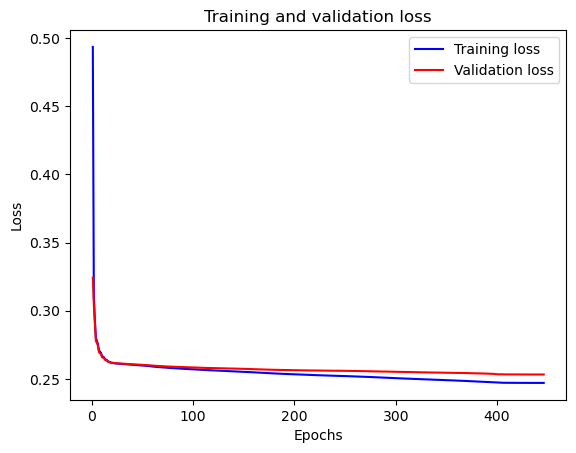

In [47]:
from utilities.plot_losses import PlotLosses
PlotLosses(train_losses, val_losses).plot_losses()

In [ ]:
for epoch in range(300, 400):
    model.train()
    print(f"Epoch [{epoch+1}/{400}]")
    train_total_loss = 0.0
    val_total_loss = 0.0
    count = 0
    latent_features = []
    for img, mask, img_name in train_data:
    #for img, mask, img_name in itertools.islice(train_data, 5):
        img, mask = img.to(device), mask.to(device)   
        latent, loss, predictions, batch_mask = model(img, mask)
        latent_features.append(latent.cpu().detach().numpy())
        train_total_loss += loss
        count += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if count % 100 == 0:
            print(f"Batch {count}/{len(train_data)}, Loss: {loss:.4f}")
    
    avg_train_loss = train_total_loss/len(train_data)
    print(f"Epoch [{epoch+1}/{400}], Training Complete. Average Training Loss: {avg_train_loss:.4f}")

    model.eval()
    with torch.no_grad():
        for val_img, val_mask, val_img_name in val_data:
        #for val_img, val_mask, val_img_name in itertools.islice(val_data, 5):
            val_img, val_mask = val_img.to(device), val_mask.to(device)
            _, val_loss, val_predictions, val_batch_mask = model(val_img, val_mask)
            val_total_loss += val_loss

    avg_val_loss = val_total_loss/len(val_data)

    print(f'Epoch [{epoch+1}/{400}], Avg Train Loss: {avg_train_loss}, Avg Val Loss: {avg_val_loss}')

    #DisplayPredictions(device, predictions, batch_mask, img_size=182, num_frames=224, patch_size=14, tubelet_size=16).disp_pred()

    # save features, model for GWAS and display
    if epoch % 10 == 0 or epoch == 399:
        with open(f'{save_features_dir}/{save_features_file}_{epoch+1}.pkl', 'wb') as f:
            print(f"Epoch [{epoch+1}]. Saving features") #of shape: {np.array(self.latent_features).shape}")
            pickle.dump(latent_features, f)
        save_checkpoint(epoch)
        DisplayPredictions(device, predictions, batch_mask, img_size=182, num_frames=224, patch_size=14, tubelet_size=16).disp_pred()
        

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

## Changing AdamW to SGD, keeping LR same

In [6]:
from torch.optim import SGD
checkpoint_path = '/data484_1/sislam6/practicum/saved_models/train_val_dataset_100_epochs_128_avgpool/model_400.pt'

model = AVGPOOLMODEL(embed_dim = embed_dim, decoder_embed_dim = decoder_embed_dim, num_heads = num_heads)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-5)

checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

train_losses = checkpoint['training_loss']
val_losses = checkpoint['validation_loss']

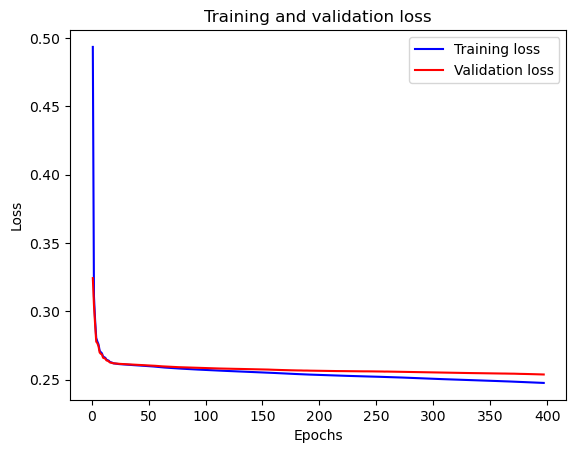

In [7]:
from utilities.plot_losses import PlotLosses
PlotLosses(train_losses, val_losses).plot_losses()

In [ ]:
for epoch in range(400, 450):
    model.train()
    print(f"Epoch [{epoch+1}/{450}]")
    train_total_loss = 0.0
    val_total_loss = 0.0
    count = 0
    latent_features = []
    for img, mask, img_name in train_data:
    #for img, mask, img_name in itertools.islice(train_data, 5):
        img, mask = img.to(device), mask.to(device)   
        latent, loss, predictions, batch_mask = model(img, mask)
        latent_features.append(latent.cpu().detach().numpy())
        train_total_loss += loss
        count += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if count % 100 == 0:
            print(f"Batch {count}/{len(train_data)}, Loss: {loss:.4f}")
    
    avg_train_loss = train_total_loss/len(train_data)
    print(f"Epoch [{epoch+1}/{450}], Training Complete. Average Training Loss: {avg_train_loss:.4f}")

    model.eval()
    with torch.no_grad():
        for val_img, val_mask, val_img_name in val_data:
        #for val_img, val_mask, val_img_name in itertools.islice(val_data, 5):
            val_img, val_mask = val_img.to(device), val_mask.to(device)
            _, val_loss, val_predictions, val_batch_mask = model(val_img, val_mask)
            val_total_loss += val_loss

    avg_val_loss = val_total_loss/len(val_data)

    print(f'Epoch [{epoch+1}/{450}], Avg Train Loss: {avg_train_loss}, Avg Val Loss: {avg_val_loss}')

    #DisplayPredictions(device, predictions, batch_mask, img_size=182, num_frames=224, patch_size=14, tubelet_size=16).disp_pred()

    # save features, model for GWAS and display
    if epoch % 10 == 0 or epoch == 449:
        with open(f'{save_features_dir}/{save_features_file}_{epoch+1}.pkl', 'wb') as f:
            print(f"Epoch [{epoch+1}]. Saving features") #of shape: {np.array(self.latent_features).shape}")
            pickle.dump(latent_features, f)
        save_checkpoint(epoch)
        DisplayPredictions(device, predictions, batch_mask, img_size=182, num_frames=224, patch_size=14, tubelet_size=16).disp_pred()
        

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

In [ ]:
from utilities.plot_losses import PlotLosses
PlotLosses(train_losses, val_losses).plot_losses()

## Chaging LR to 1e-6

In [46]:
checkpoint_path = '/data484_1/sislam6/practicum/saved_models/train_val_dataset_100_epochs_128_avgpool/model_450.pt'

model = AVGPOOLMODEL(embed_dim = embed_dim, decoder_embed_dim = decoder_embed_dim, num_heads = num_heads)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-6)

checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

train_losses = checkpoint['training_loss']
val_losses = checkpoint['validation_loss']

Epoch [451/500]


/data484_1/sislam6/anaconda3/envs/practicum/lib/python3.8/site-packages/torch/nn/modules/conv.py:605: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1711403590347/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv3d(


Batch 100/2299, Loss: 0.2606
Batch 200/2299, Loss: 0.2458
Batch 300/2299, Loss: 0.2602
Batch 400/2299, Loss: 0.2784
Batch 500/2299, Loss: 0.2442
Batch 600/2299, Loss: 0.2167
Batch 700/2299, Loss: 0.2443
Batch 800/2299, Loss: 0.2669
Batch 900/2299, Loss: 0.2492
Batch 1000/2299, Loss: 0.2347
Batch 1100/2299, Loss: 0.2349
Batch 1200/2299, Loss: 0.2883
Batch 1300/2299, Loss: 0.2654
Batch 1400/2299, Loss: 0.2283
Batch 1500/2299, Loss: 0.2348
Batch 1600/2299, Loss: 0.2504
Batch 1700/2299, Loss: 0.2203
Batch 1800/2299, Loss: 0.2605
Batch 1900/2299, Loss: 0.2675
Batch 2000/2299, Loss: 0.2504
Batch 2100/2299, Loss: 0.2460
Batch 2200/2299, Loss: 0.2492
Epoch [451/500], Training Complete. Average Training Loss: 0.2471
Epoch [451/500], Avg Train Loss: 0.2470724731683731, Avg Val Loss: 0.25324758887290955
Epoch [451]. Saving features
Epoch [451]. Model saved to /data484_1/sislam6/practicum/saved_models/train_val_dataset_100_epochs_128_avgpool/model_451.pt


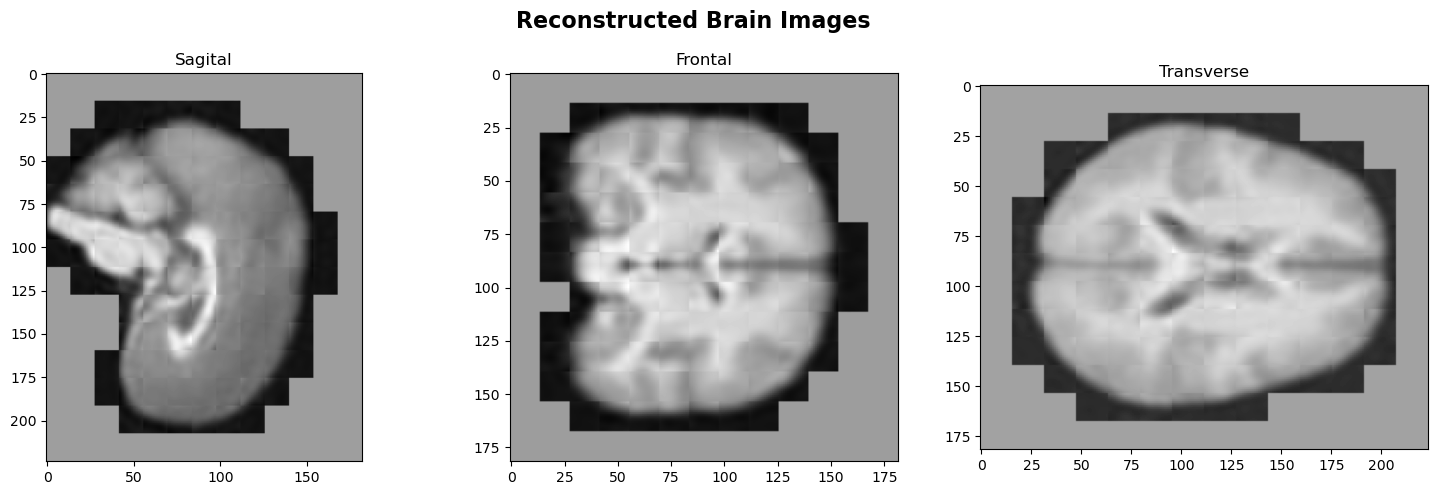

Epoch [452/500]
Batch 100/2299, Loss: 0.2606
Batch 200/2299, Loss: 0.2458
Batch 300/2299, Loss: 0.2602
Batch 400/2299, Loss: 0.2784
Batch 500/2299, Loss: 0.2442
Batch 600/2299, Loss: 0.2167
Batch 700/2299, Loss: 0.2443
Batch 800/2299, Loss: 0.2669
Batch 900/2299, Loss: 0.2492
Batch 1000/2299, Loss: 0.2347
Batch 1100/2299, Loss: 0.2349
Batch 1200/2299, Loss: 0.2883
Batch 1300/2299, Loss: 0.2654
Batch 1400/2299, Loss: 0.2283
Batch 1500/2299, Loss: 0.2348
Batch 1600/2299, Loss: 0.2504
Batch 1700/2299, Loss: 0.2203
Batch 1800/2299, Loss: 0.2605
Batch 1900/2299, Loss: 0.2675
Batch 2000/2299, Loss: 0.2504
Batch 2100/2299, Loss: 0.2460
Batch 2200/2299, Loss: 0.2492
Epoch [452/500], Training Complete. Average Training Loss: 0.2471
Epoch [452/500], Avg Train Loss: 0.24707241356372833, Avg Val Loss: 0.2532476782798767
Epoch [453/500]
Batch 100/2299, Loss: 0.2606
Batch 200/2299, Loss: 0.2458
Batch 300/2299, Loss: 0.2602
Batch 400/2299, Loss: 0.2784
Batch 500/2299, Loss: 0.2442
Batch 600/2299, Los

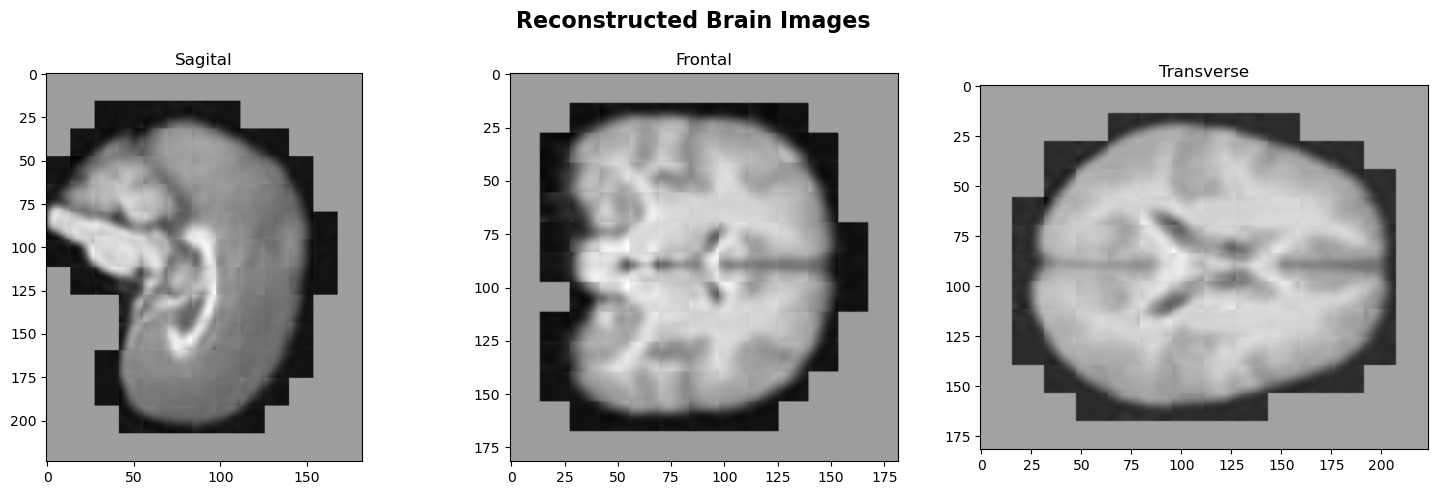

Epoch [462/500]
Batch 100/2299, Loss: 0.2605
Batch 200/2299, Loss: 0.2458
Batch 300/2299, Loss: 0.2602
Batch 400/2299, Loss: 0.2784
Batch 500/2299, Loss: 0.2442
Batch 600/2299, Loss: 0.2167
Batch 700/2299, Loss: 0.2443
Batch 800/2299, Loss: 0.2669
Batch 900/2299, Loss: 0.2492
Batch 1000/2299, Loss: 0.2347
Batch 1100/2299, Loss: 0.2349
Batch 1200/2299, Loss: 0.2883
Batch 1300/2299, Loss: 0.2654
Batch 1400/2299, Loss: 0.2283
Batch 1500/2299, Loss: 0.2348
Batch 1600/2299, Loss: 0.2504
Batch 1700/2299, Loss: 0.2203
Batch 1800/2299, Loss: 0.2605
Batch 1900/2299, Loss: 0.2675
Batch 2000/2299, Loss: 0.2504
Batch 2100/2299, Loss: 0.2460
Batch 2200/2299, Loss: 0.2492
Epoch [462/500], Training Complete. Average Training Loss: 0.2471
Epoch [462/500], Avg Train Loss: 0.24707186222076416, Avg Val Loss: 0.2532488703727722
Epoch [463/500]
Batch 100/2299, Loss: 0.2605
Batch 200/2299, Loss: 0.2458
Batch 300/2299, Loss: 0.2602
Batch 400/2299, Loss: 0.2784
Batch 500/2299, Loss: 0.2442
Batch 600/2299, Los

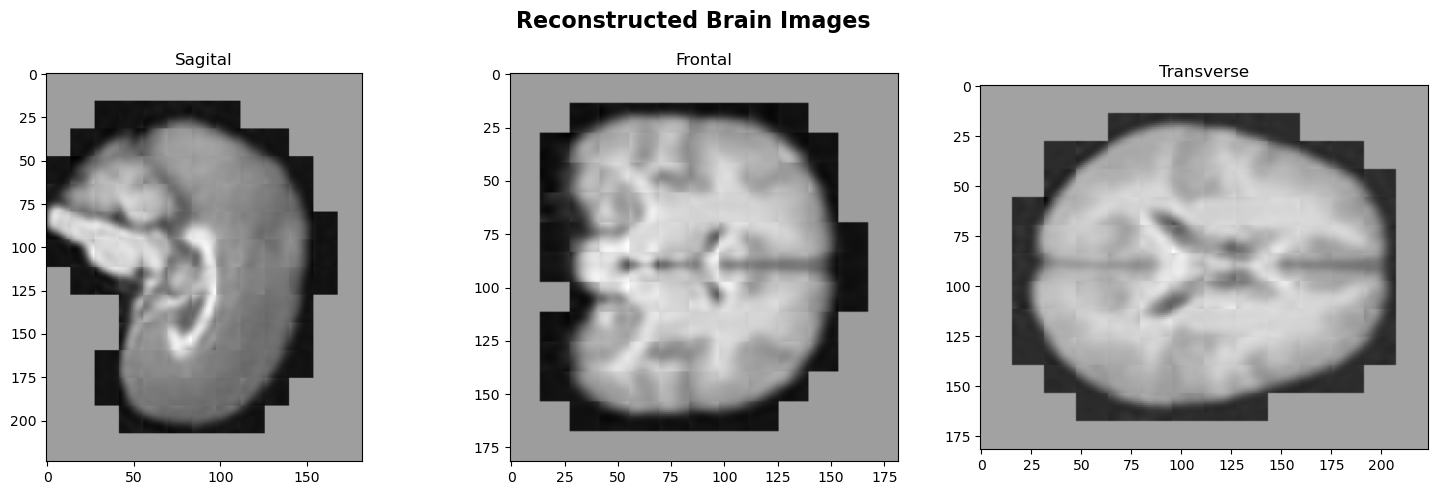

Epoch [472/500]
Batch 100/2299, Loss: 0.2605
Batch 200/2299, Loss: 0.2458
Batch 300/2299, Loss: 0.2602
Batch 400/2299, Loss: 0.2784
Batch 500/2299, Loss: 0.2442
Batch 600/2299, Loss: 0.2166
Batch 700/2299, Loss: 0.2443
Batch 800/2299, Loss: 0.2669
Batch 900/2299, Loss: 0.2492
Batch 1000/2299, Loss: 0.2347
Batch 1100/2299, Loss: 0.2349
Batch 1200/2299, Loss: 0.2884
Batch 1300/2299, Loss: 0.2654
Batch 1400/2299, Loss: 0.2283
Batch 1500/2299, Loss: 0.2348
Batch 1600/2299, Loss: 0.2504
Batch 1700/2299, Loss: 0.2203
Batch 1800/2299, Loss: 0.2605
Batch 1900/2299, Loss: 0.2676
Batch 2000/2299, Loss: 0.2504
Batch 2100/2299, Loss: 0.2460
Batch 2200/2299, Loss: 0.2492
Epoch [472/500], Training Complete. Average Training Loss: 0.2471
Epoch [472/500], Avg Train Loss: 0.2470715045928955, Avg Val Loss: 0.2532486021518707
Epoch [473/500]
Batch 100/2299, Loss: 0.2605
Batch 200/2299, Loss: 0.2458
Batch 300/2299, Loss: 0.2602
Batch 400/2299, Loss: 0.2784
Batch 500/2299, Loss: 0.2442
Batch 600/2299, Loss

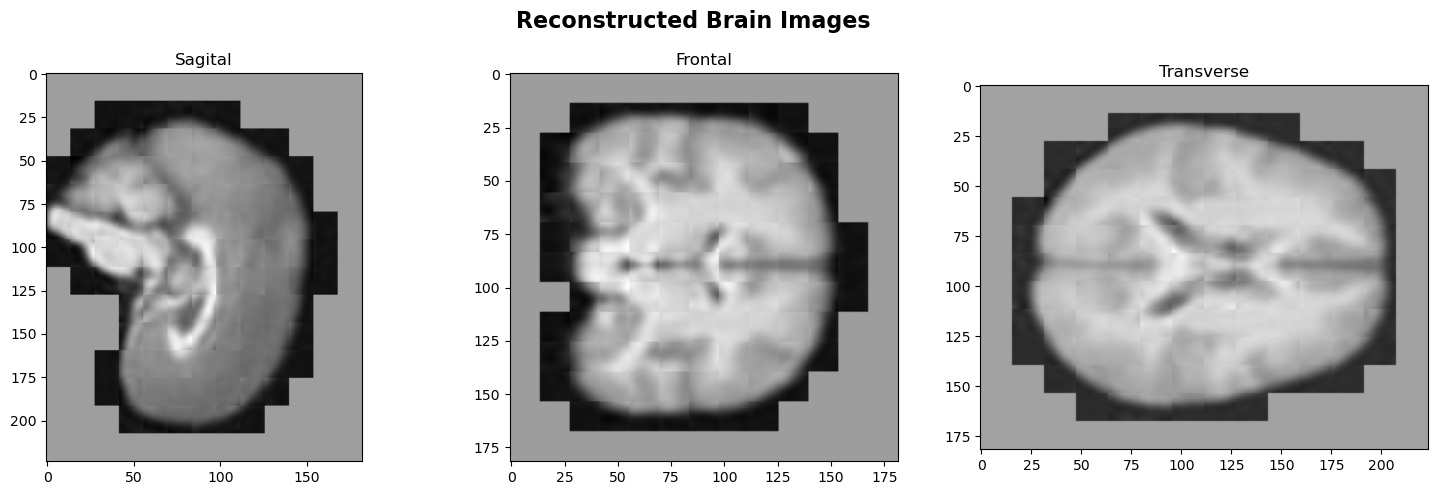

Epoch [482/500]
Batch 100/2299, Loss: 0.2605
Batch 200/2299, Loss: 0.2458
Batch 300/2299, Loss: 0.2602
Batch 400/2299, Loss: 0.2784
Batch 500/2299, Loss: 0.2442
Batch 600/2299, Loss: 0.2166
Batch 700/2299, Loss: 0.2443
Batch 800/2299, Loss: 0.2669
Batch 900/2299, Loss: 0.2492
Batch 1000/2299, Loss: 0.2347
Batch 1100/2299, Loss: 0.2349
Batch 1200/2299, Loss: 0.2884
Batch 1300/2299, Loss: 0.2654
Batch 1400/2299, Loss: 0.2283
Batch 1500/2299, Loss: 0.2348
Batch 1600/2299, Loss: 0.2504
Batch 1700/2299, Loss: 0.2203
Batch 1800/2299, Loss: 0.2605
Batch 1900/2299, Loss: 0.2676
Batch 2000/2299, Loss: 0.2504
Batch 2100/2299, Loss: 0.2460
Batch 2200/2299, Loss: 0.2492
Epoch [482/500], Training Complete. Average Training Loss: 0.2471
Epoch [482/500], Avg Train Loss: 0.2470710277557373, Avg Val Loss: 0.2532484233379364
Epoch [483/500]
Batch 100/2299, Loss: 0.2605
Batch 200/2299, Loss: 0.2458
Batch 300/2299, Loss: 0.2602
Batch 400/2299, Loss: 0.2784
Batch 500/2299, Loss: 0.2442
Batch 600/2299, Loss

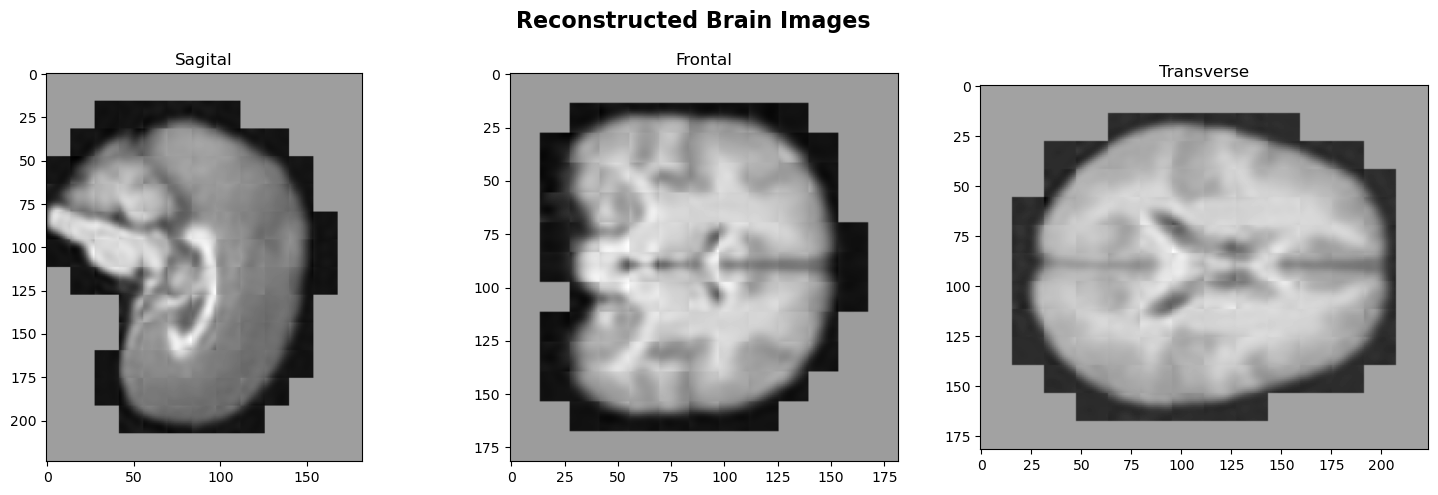

Epoch [492/500]
Batch 100/2299, Loss: 0.2605
Batch 200/2299, Loss: 0.2458
Batch 300/2299, Loss: 0.2602
Batch 400/2299, Loss: 0.2784
Batch 500/2299, Loss: 0.2442
Batch 600/2299, Loss: 0.2166
Batch 700/2299, Loss: 0.2443
Batch 800/2299, Loss: 0.2669
Batch 900/2299, Loss: 0.2492
Batch 1000/2299, Loss: 0.2347
Batch 1100/2299, Loss: 0.2349
Batch 1200/2299, Loss: 0.2883
Batch 1300/2299, Loss: 0.2654
Batch 1400/2299, Loss: 0.2283
Batch 1500/2299, Loss: 0.2348
Batch 1600/2299, Loss: 0.2504
Batch 1700/2299, Loss: 0.2203
Batch 1800/2299, Loss: 0.2605
Batch 1900/2299, Loss: 0.2676
Batch 2000/2299, Loss: 0.2504
Batch 2100/2299, Loss: 0.2461
Batch 2200/2299, Loss: 0.2492
Epoch [492/500], Training Complete. Average Training Loss: 0.2471
Epoch [492/500], Avg Train Loss: 0.24707061052322388, Avg Val Loss: 0.2532481551170349
Epoch [493/500]
Batch 100/2299, Loss: 0.2605
Batch 200/2299, Loss: 0.2458
Batch 300/2299, Loss: 0.2602
Batch 400/2299, Loss: 0.2784
Batch 500/2299, Loss: 0.2442
Batch 600/2299, Los

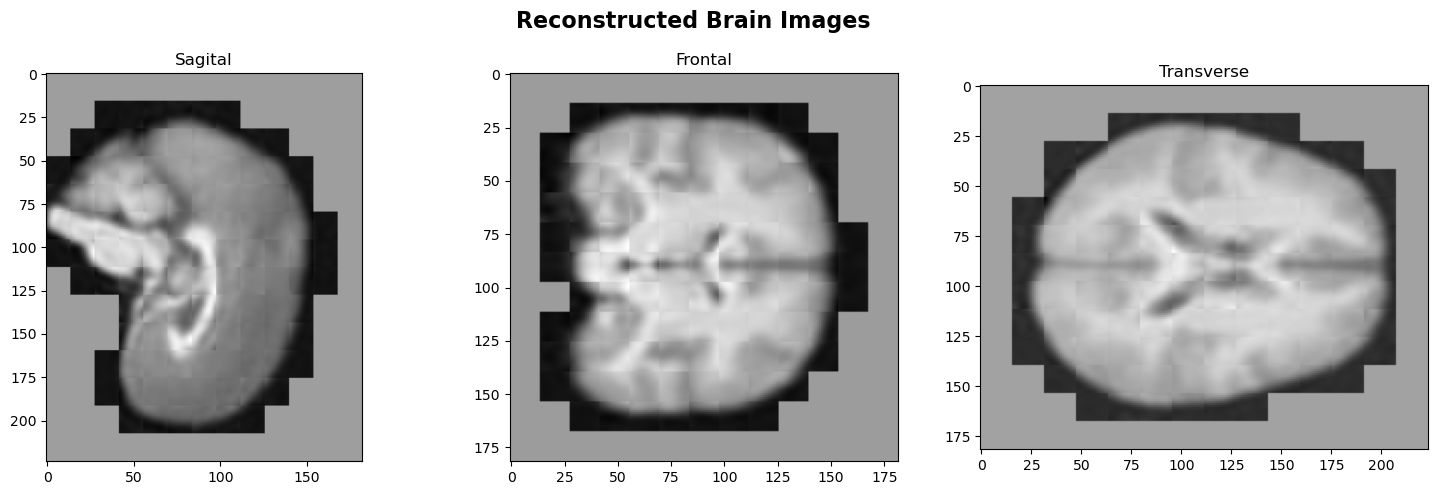

In [9]:
for epoch in range(450, 500):
    model.train()
    print(f"Epoch [{epoch+1}/{500}]")
    train_total_loss = 0.0
    val_total_loss = 0.0
    count = 0
    latent_features = []
    for img, mask, img_name in train_data:
    #for img, mask, img_name in itertools.islice(train_data, 5):
        img, mask = img.to(device), mask.to(device)   
        latent, loss, predictions, batch_mask = model(img, mask)
        latent_features.append(latent.cpu().detach().numpy())
        train_total_loss += loss
        count += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if count % 100 == 0:
            print(f"Batch {count}/{len(train_data)}, Loss: {loss:.4f}")
    
    avg_train_loss = train_total_loss/len(train_data)
    print(f"Epoch [{epoch+1}/{500}], Training Complete. Average Training Loss: {avg_train_loss:.4f}")

    model.eval()
    with torch.no_grad():
        for val_img, val_mask, val_img_name in val_data:
        #for val_img, val_mask, val_img_name in itertools.islice(val_data, 5):
            val_img, val_mask = val_img.to(device), val_mask.to(device)
            _, val_loss, val_predictions, val_batch_mask = model(val_img, val_mask)
            val_total_loss += val_loss

    avg_val_loss = val_total_loss/len(val_data)

    print(f'Epoch [{epoch+1}/{500}], Avg Train Loss: {avg_train_loss}, Avg Val Loss: {avg_val_loss}')

    #DisplayPredictions(device, predictions, batch_mask, img_size=182, num_frames=224, patch_size=14, tubelet_size=16).disp_pred()

    # save features, model for GWAS and display
    if epoch % 10 == 0 or epoch == 499:
        with open(f'{save_features_dir}/{save_features_file}_{epoch+1}.pkl', 'wb') as f:
            print(f"Epoch [{epoch+1}]. Saving features") #of shape: {np.array(self.latent_features).shape}")
            pickle.dump(latent_features, f)
        save_checkpoint(epoch)
        DisplayPredictions(device, predictions, batch_mask, img_size=182, num_frames=224, patch_size=14, tubelet_size=16).disp_pred()
        

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

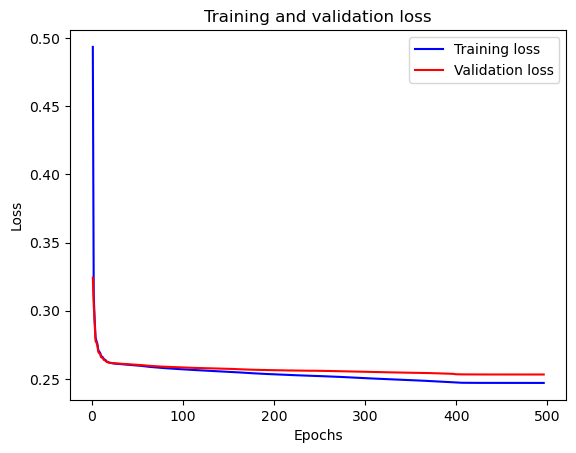

In [10]:
from utilities.plot_losses import PlotLosses
PlotLosses(train_losses, val_losses).plot_losses()

In [20]:
for img, mask, img_name in train_data:
    print(img_name)

['/data5/kpatel38/MRI/T1_New/T1_extracted/3859555_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz', '/data5/kpatel38/MRI/T1_New/T1_extracted/2041209_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz']
['/data5/kpatel38/MRI/T1_New/T1_extracted/1859094_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz', '/data5/kpatel38/MRI/T1_New/T1_extracted/5172028_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz']
['/data5/kpatel38/MRI/T1_New/T1_extracted/1189108_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz', '/data5/kpatel38/MRI/T1_New/T1_extracted/3971989_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz']
['/data5/kpatel38/MRI/T1_New/T1_extracted/2206998_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz', '/data5/kpatel38/MRI/T1_New/T1_extracted/4913166_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz']
['/data5/kpatel38/MRI/T1_New/T1_extracted/2622091_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz', '/data5/kpatel38/MRI/T1_New/T1_extracted/3005806_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz']
['/data5/kpatel38/MRI/T1_New/T1_ext

In [15]:
len(train_data)

2299

In [66]:
from torch.optim import SGD
checkpoint_path = '/data484_1/sislam6/practicum/saved_models/train_val_dataset_100_epochs_128_avgpool/model_450.pt'

model = AVGPOOLMODEL(embed_dim = embed_dim, decoder_embed_dim = decoder_embed_dim, num_heads = num_heads)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-5)

checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

train_losses = checkpoint['training_loss']
val_losses = checkpoint['validation_loss']

In [24]:
for epoch in range(500, 501):
    model.train()
    print(f"Epoch [{epoch+1}/{500}]")
    train_total_loss = 0.0
    val_total_loss = 0.0
    count = 0
    latent_features = []
    for img, mask, img_name in train_data:
    #for img, mask, img_name in itertools.islice(train_data, 5):
        img, mask = img.to(device), mask.to(device)   
        latent, loss, predictions, batch_mask = model(img, mask)
        print(predictions.shape)
        latent_features.append(latent.cpu().detach().numpy())
        train_total_loss += loss
        count += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if count % 100 == 0:
            print(f"Batch {count}/{len(train_data)}, Loss: {loss:.4f}")
    
    avg_train_loss = train_total_loss/len(train_data)
    print(f"Epoch [{epoch+1}/{500}], Training Complete. Average Training Loss: {avg_train_loss:.4f}")

    '''model.eval()
    with torch.no_grad():
        for val_img, val_mask, val_img_name in val_data:
        #for val_img, val_mask, val_img_name in itertools.islice(val_data, 5):
            val_img, val_mask = val_img.to(device), val_mask.to(device)
            _, val_loss, val_predictions, val_batch_mask = model(val_img, val_mask)
            val_total_loss += val_loss

    avg_val_loss = val_total_loss/len(val_data)

    print(f'Epoch [{epoch+1}/{500}], Avg Train Loss: {avg_train_loss}, Avg Val Loss: {avg_val_loss}')

    #DisplayPredictions(device, predictions, batch_mask, img_size=182, num_frames=224, patch_size=14, tubelet_size=16).disp_pred()
'''
    # save features, model for GWAS and display
    if epoch % 10 == 0 or epoch == 499:
        with open(f'{save_features_dir}/{save_features_file}_{epoch+1}.pkl', 'wb') as f:
            print(f"Epoch [{epoch+1}]. Saving features") #of shape: {np.array(self.latent_features).shape}")
            pickle.dump(latent_features, f)
        save_checkpoint(epoch)
        DisplayPredictions(device, predictions, batch_mask, img_size=182, num_frames=224, patch_size=14, tubelet_size=16).disp_pred()
        

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

Epoch [501/500]


/data484_1/sislam6/anaconda3/envs/practicum/lib/python3.8/site-packages/torch/nn/modules/conv.py:605: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1711403590347/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv3d(


torch.Size([2, 971, 3136])
torch.Size([2, 1001, 3136])
torch.Size([2, 976, 3136])
torch.Size([2, 978, 3136])
torch.Size([2, 976, 3136])
torch.Size([2, 1007, 3136])
torch.Size([2, 989, 3136])
torch.Size([2, 977, 3136])
torch.Size([2, 1002, 3136])
torch.Size([2, 993, 3136])
torch.Size([2, 998, 3136])
torch.Size([2, 1002, 3136])
torch.Size([2, 1003, 3136])
torch.Size([2, 1023, 3136])
torch.Size([2, 1002, 3136])
torch.Size([2, 980, 3136])
torch.Size([2, 983, 3136])
torch.Size([2, 993, 3136])
torch.Size([2, 970, 3136])
torch.Size([2, 1000, 3136])
torch.Size([2, 989, 3136])
torch.Size([2, 1013, 3136])
torch.Size([2, 997, 3136])
torch.Size([2, 992, 3136])
torch.Size([2, 992, 3136])
torch.Size([2, 982, 3136])
torch.Size([2, 995, 3136])
torch.Size([2, 1020, 3136])
torch.Size([2, 979, 3136])
torch.Size([2, 996, 3136])
torch.Size([2, 1003, 3136])
torch.Size([2, 978, 3136])
torch.Size([2, 1007, 3136])
torch.Size([2, 1002, 3136])
torch.Size([2, 1025, 3136])
torch.Size([2, 973, 3136])
torch.Size([2,

KeyboardInterrupt: 

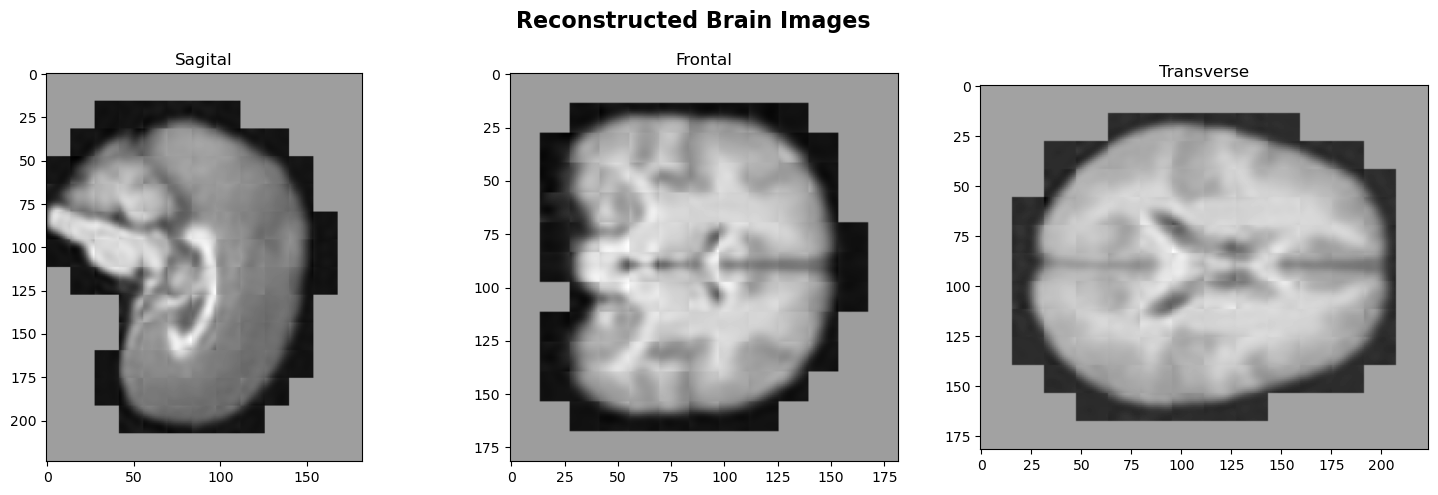

In [45]:
DisplayPredictions(device, predictions, batch_mask, img_size=182, num_frames=224, patch_size=14, tubelet_size=16).disp_pred()

In [60]:
patch_vol = 14 * 16 * 14
num_patches = 13*14*13

In [61]:
empty_img = torch.zeros((2, num_patches, patch_vol))
empty_img = empty_img.to(device)
empty_img[:, batch_mask, :] = predictions
recon_img = empty_img.view(2,13,14,13,14,16,14).permute(0,1,4,2,5,3,6).\
        reshape(-1,182,224,182)

In [62]:
predictions.shape

torch.Size([2, 971, 3136])

In [63]:
recon_img.shape

torch.Size([2, 182, 224, 182])

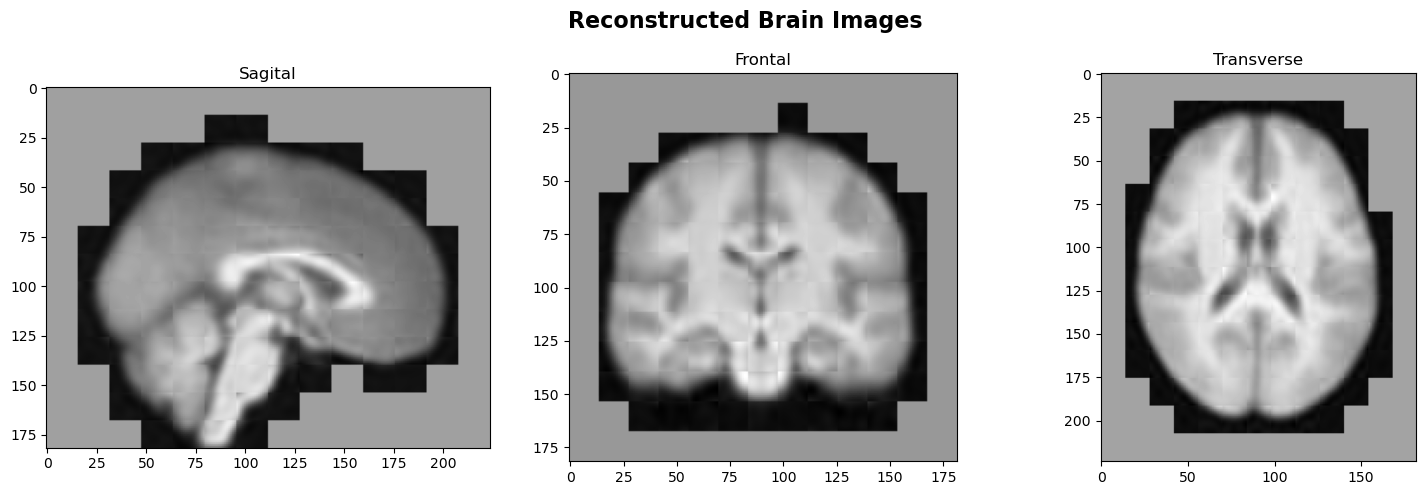

In [65]:
recon_img_0 = recon_img[1]
recon_img_0 = recon_img_0.detach()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5)) 

recon_img_0 = recon_img_0.cpu() # move back to CPU to visualize

axes[0].imshow(np.rot90(recon_img_0[recon_img_0.shape[0] // 2, :, :]), cmap='gray')  
axes[0].set_title('Sagital')

axes[1].imshow(np.rot90(recon_img_0[:, recon_img_0.shape[1] // 2, :]), cmap='gray')
axes[1].set_title('Frontal')

axes[2].imshow(np.rot90(recon_img_0[:, :, recon_img_0.shape[2] // 2]), cmap='gray')
axes[2].set_title('Transverse')

fig.suptitle('Reconstructed Brain Images', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

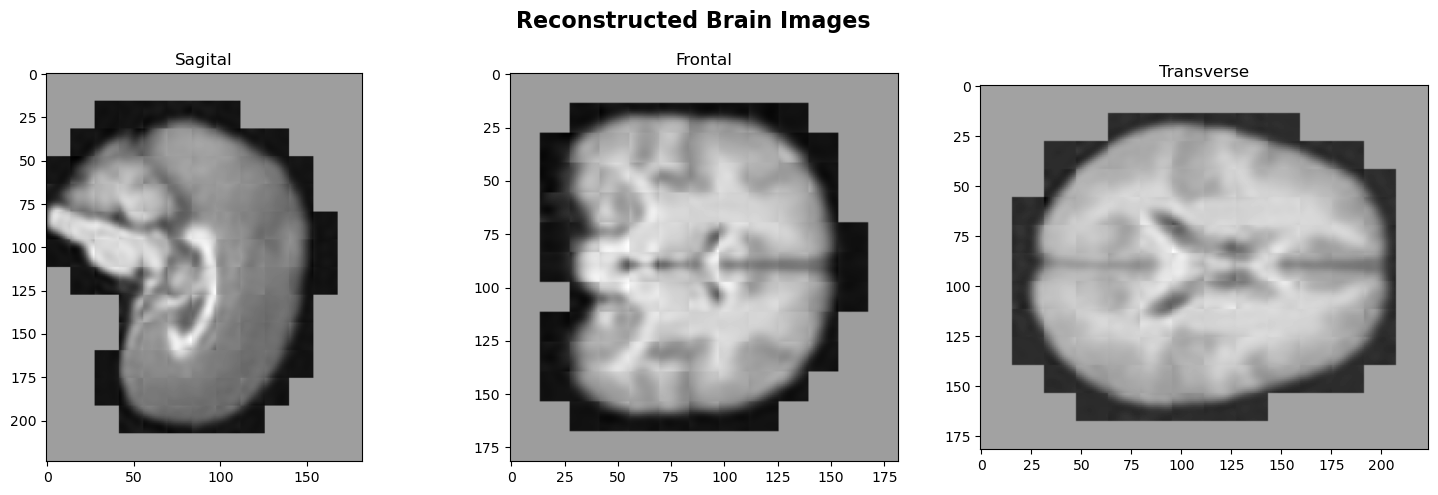

In [39]:
recon_img_1 = recon_img[1]
recon_img_1 = recon_img_1.detach()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5)) 

recon_img_1 = recon_img_1.cpu() # move back to CPU to visualize

axes[0].imshow(recon_img_1[recon_img_1.shape[0] // 2, :, :], cmap='gray')  
axes[0].set_title('Sagital')

axes[1].imshow(recon_img_1[:, recon_img_1.shape[1] // 2, :], cmap='gray')
axes[1].set_title('Frontal')

axes[2].imshow(recon_img_1[:, :, recon_img_1.shape[2] // 2], cmap='gray')
axes[2].set_title('Transverse')

fig.suptitle('Reconstructed Brain Images', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

Epoch [451/451]
['/data5/kpatel38/MRI/T1_New/T1_extracted/3859555_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz', '/data5/kpatel38/MRI/T1_New/T1_extracted/2041209_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz']
['/data5/kpatel38/MRI/T1_New/T1_extracted/1859094_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz', '/data5/kpatel38/MRI/T1_New/T1_extracted/5172028_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz']
['/data5/kpatel38/MRI/T1_New/T1_extracted/1189108_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz', '/data5/kpatel38/MRI/T1_New/T1_extracted/3971989_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz']
['/data5/kpatel38/MRI/T1_New/T1_extracted/2206998_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz', '/data5/kpatel38/MRI/T1_New/T1_extracted/4913166_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz']
['/data5/kpatel38/MRI/T1_New/T1_extracted/2622091_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz', '/data5/kpatel38/MRI/T1_New/T1_extracted/3005806_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz']
['/data5/kpatel38/M

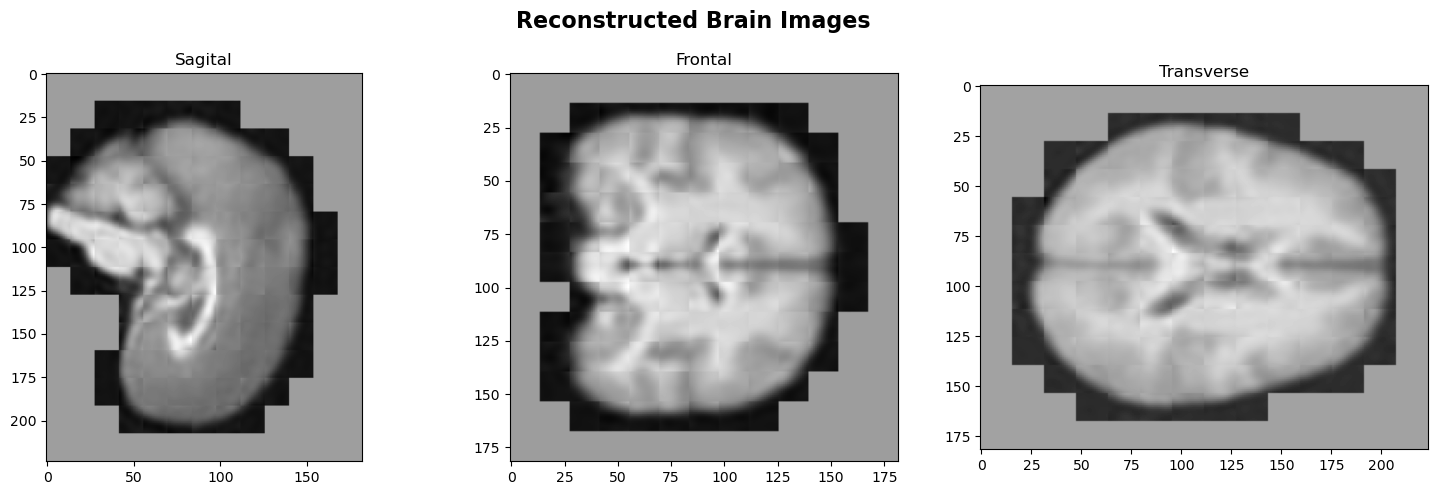

'\n    model.eval()\n    with torch.no_grad():\n        for val_img, val_mask, val_img_name in val_data:\n        #for val_img, val_mask, val_img_name in itertools.islice(val_data, 5):\n            val_img, val_mask = val_img.to(device), val_mask.to(device)\n            _, val_loss, val_predictions, val_batch_mask = model(val_img, val_mask)\n            val_total_loss += val_loss\n\n    avg_val_loss = val_total_loss/len(val_data)\n\n    print(f\'Epoch [{epoch+1}/{500}], Avg Train Loss: {avg_train_loss}, Avg Val Loss: {avg_val_loss}\')\n\n    \n\n    # save features, model for GWAS and display\n    #if epoch % 10 == 0 or epoch == 399:\n    with open(f\'{save_features_dir}/{save_features_file}_{epoch+1}.pkl\', \'wb\') as f:\n        print(f"Epoch [{epoch+1}]. Saving features") #of shape: {np.array(self.latent_features).shape}")\n        pickle.dump(latent_features, f)\n    save_checkpoint(epoch)\n    DisplayPredictions(device, predictions, batch_mask, img_size=182, num_frames=224, patch_

In [75]:
target_img_name = '/data5/kpatel38/MRI/T1_New/T1_extracted/6014636_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz'
for epoch in range(450, 451):
    model.train()
    print(f"Epoch [{epoch+1}/{451}]")
    train_total_loss = 0.0
    val_total_loss = 0.0
    count = 0
    latent_features = []
    for img, mask, img_name in train_data:
    #for img, mask, img_name in itertools.islice(train_data, 2): 
        print(img_name)
        if img_name[0] != target_img_name:  # Assuming batch size = 1
            continue  # Skip images that don't match
        img, mask = img.to(device), mask.to(device)   
        latent, loss, predictions, batch_mask = model(img, mask)
        latent_features.append(latent.cpu().detach().numpy())
        train_total_loss += loss
        count += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    DisplayPredictions(device, predictions, batch_mask, img_size=182, num_frames=224, patch_size=14, tubelet_size=16).disp_pred()

    #    if count % 100 == 0:
    #        print(f"Batch {count}/{len(train_data)}, Loss: {loss:.4f}")
    
    #avg_train_loss = train_total_loss/len(train_data)
    #print(f"Epoch [{epoch+1}/{500}], Training Complete. Average Training Loss: {avg_train_loss:.4f}")
'''
    model.eval()
    with torch.no_grad():
        for val_img, val_mask, val_img_name in val_data:
        #for val_img, val_mask, val_img_name in itertools.islice(val_data, 5):
            val_img, val_mask = val_img.to(device), val_mask.to(device)
            _, val_loss, val_predictions, val_batch_mask = model(val_img, val_mask)
            val_total_loss += val_loss

    avg_val_loss = val_total_loss/len(val_data)

    print(f'Epoch [{epoch+1}/{500}], Avg Train Loss: {avg_train_loss}, Avg Val Loss: {avg_val_loss}')

    

    # save features, model for GWAS and display
    #if epoch % 10 == 0 or epoch == 399:
    with open(f'{save_features_dir}/{save_features_file}_{epoch+1}.pkl', 'wb') as f:
        print(f"Epoch [{epoch+1}]. Saving features") #of shape: {np.array(self.latent_features).shape}")
        pickle.dump(latent_features, f)
    save_checkpoint(epoch)
    DisplayPredictions(device, predictions, batch_mask, img_size=182, num_frames=224, patch_size=14, tubelet_size=16).disp_pred()
 '''       

    #train_losses.append(avg_train_loss)
    #val_losses.append(avg_val_loss)
    

In [84]:
predictions.shape

torch.Size([1, 984, 3136])

In [80]:
empty_img = torch.zeros((2, num_patches, patch_vol))
empty_img = empty_img.to(device)
empty_img[:, batch_mask, :] = predictions
recon_img = empty_img.view(2,13,14,13,14,16,14).permute(0,1,4,2,5,3,6).\
        reshape(-1,182,224,182)

In [81]:
recon_img.shape

torch.Size([2, 182, 224, 182])

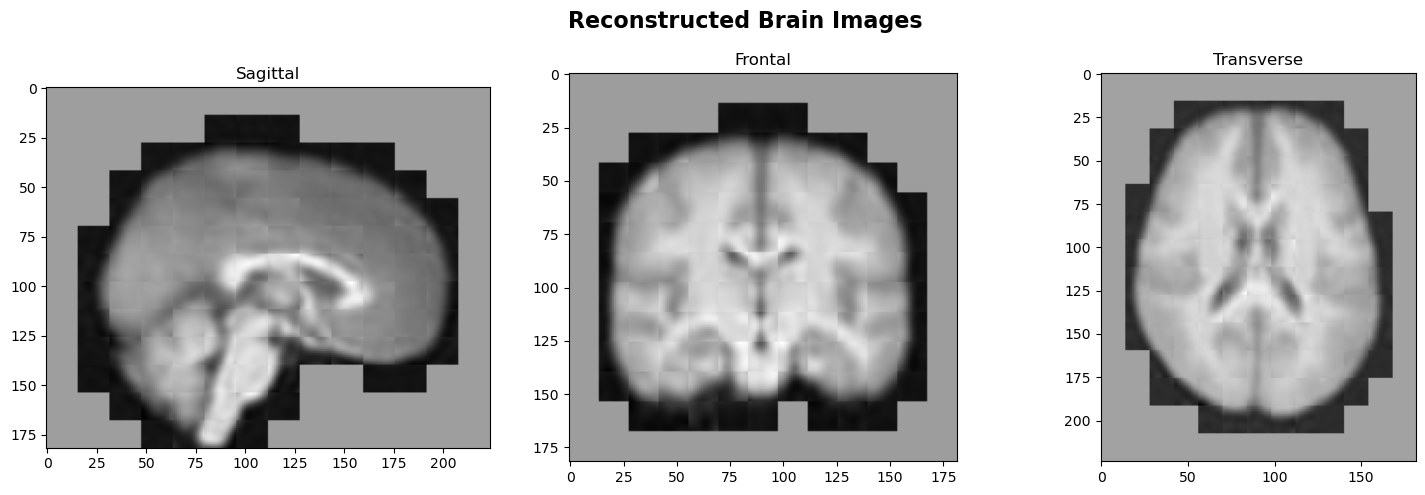

In [83]:
recon_img_0 = recon_img[1]
recon_img_0 = recon_img_0.detach()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5)) 

recon_img_0 = recon_img_0.cpu() # move back to CPU to visualize

axes[0].imshow(np.rot90(recon_img_0[recon_img_0.shape[0] // 2, :, :]), cmap='gray')  
axes[0].set_title('Sagittal')

axes[1].imshow(np.rot90(recon_img_0[:, recon_img_0.shape[1] // 2, :]), cmap='gray')
axes[1].set_title('Frontal')

axes[2].imshow(np.rot90(recon_img_0[:, :, recon_img_0.shape[2] // 2]), cmap='gray')
axes[2].set_title('Transverse')

fig.suptitle('Reconstructed Brain Images', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

In [59]:
predictions.shape

torch.Size([2, 971, 3136])

In [85]:
import nibabel as nib
img = nib.load('/data5/kpatel38/MRI/T1_New/T1_extracted/6014636_20252_2_0/T1/T1_unbiased_brain_linear.nii.gz')
img = img.get_fdata()
img = torch.from_numpy(img)
img = torch.nn.functional.pad(img, (0,0,3,3,0,0))
img = (img - img[img != 0].mean()) / img[img != 0].std()
img = img.type(torch.float)
img.shape

torch.Size([182, 224, 182])

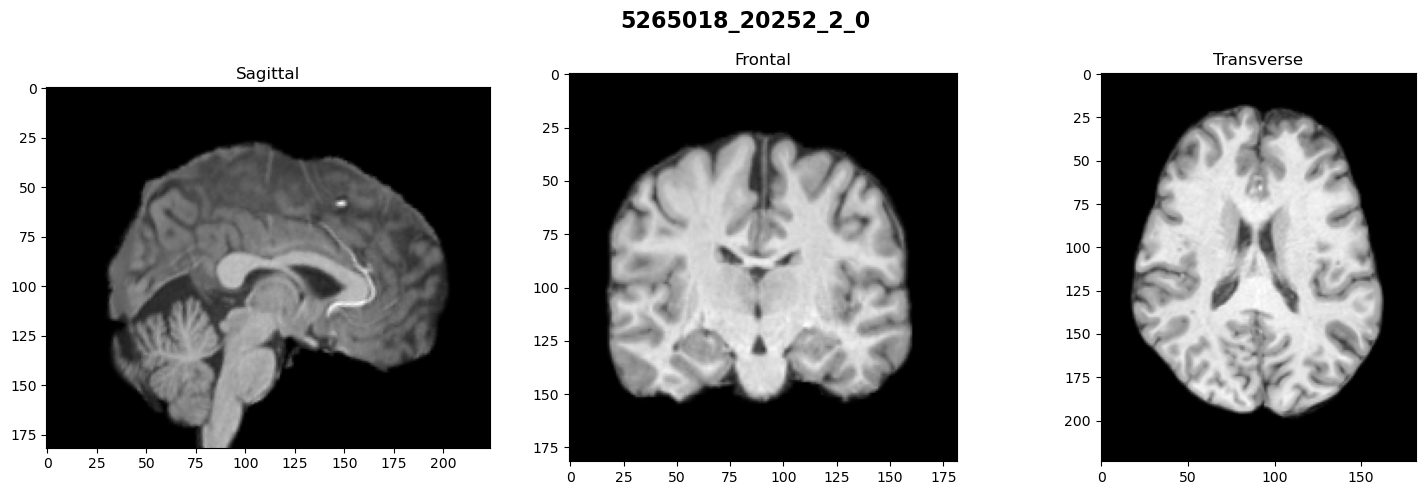

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5)) 

axes[0].imshow(np.rot90(img[img.shape[0] // 2, :, :]), cmap='gray')  
axes[0].set_title('Sagittal')

axes[1].imshow(np.rot90(img[:, img.shape[1] // 2, :]), cmap='gray')
axes[1].set_title('Frontal')

axes[2].imshow(np.rot90(img[:, :, img.shape[2] // 2]), cmap='gray')
axes[2].set_title('Transverse')

fig.suptitle('Original ', fontsize=16, fontweight='bold')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()